In [2]:
import numpy as np
import pandas as pd
import glob


import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline


rc = {'axes.facecolor': '#E3DCD1',
      'font.family': 'Lucida Sans Unicode',
      'grid.linestyle': '-',
      'grid.linewidth': '0.75',
      'grid.color': '#ffffff',
      'mathtext.fontset': 'stixsans',
      'mathtext.sf': 'sans',
      'legend.frameon': True}
plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
plt.rc('mathtext', fontset='stixsans', sf='sans')
sns.set_style('darkgrid', rc=rc)
sns.set_palette("colorblind", color_codes=True)
sns.set(rc=rc)


## Outline for notebook

In this notebook I'm going to organize all the requests that RP has made from me in sifting through the Schmidt et. al. and related data. Compared to more focused cell biology work that looks at a speicifc type of protein, this dataset essentially gives us everything. With the addition of many growth conditions, we have a rich set of protein copy numbers that covers biological activity ranging from transcription and translation, to more fundamental aspects of energy utilization and synthesis. Protein groups to be looked at:


- ATP synthase

- RNA polymerase and sigma factors

- DNA polymerase

- Glucose transporters

- ribosomes

In [3]:
combined_df = pd.read_csv('../../../data/combined_copynumbers_Schmidt_Li_Tanguichi.csv')
combined_df = combined_df[combined_df.dataset == 'Schmidt']
combined_df.head()

,Unnamed: 0,Annotated functional COG class,Annotated functional COG group (description),Annotated functional COG groups (letter),Gene,condition,copy_number,copy_number_stdev,dataset,growth_rate,type
0,0,INFORMATION STORAGE AND PROCESSING,"Translation, ribosomal structure and biogenesis",J,rplA,Glucose,28502.0,4514.7168,Schmidt,0.58,ribosomal
1,1,INFORMATION STORAGE AND PROCESSING,"Translation, ribosomal structure and biogenesis",J,rplA,LB,76877.0,1614.4170,Schmidt,1.90,ribosomal
2,2,INFORMATION STORAGE AND PROCESSING,"Translation, ribosomal structure and biogenesis",J,rplA,Glycerol + AA,47366.0,587.3384,Schmidt,1.27,ribosomal
3,3,INFORMATION STORAGE AND PROCESSING,"Translation, ribosomal structure and biogenesis",J,rplA,Acetate,11672.0,466.8800,Schmidt,0.30,ribosomal
4,4,INFORMATION STORAGE AND PROCESSING,"Translation, ribosomal structure and biogenesis",J,rplA,Fumarate,17445.0,439.6140,Schmidt,0.42,ribosomal


## general look at the numbers

Lets take a quick look at how the general COG classes vary with growth rate / growth condition.  Here I'll use the COG functional description in the Schmidt et al. dataset. 

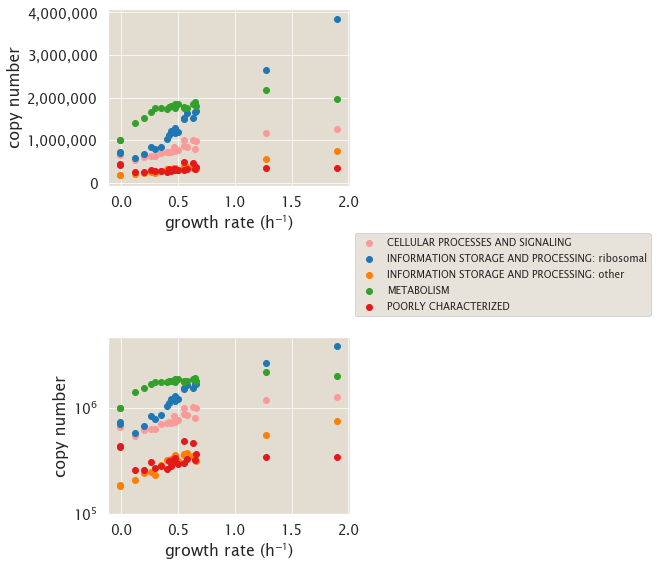

In [313]:
# set color for each dataset
# pal = sns.color_palette(palette='colorblind', n_colors=8)
pal = sns.color_palette("Paired", 10)
colorlist = pal.as_hex()
datasets_arr = np.append(combined_df.dataset.unique(), 
            combined_df['Annotated functional COG class'].unique())
color_dict = dict(zip(datasets_arr, colorlist))


fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,8))

for group, data in combined_df.groupby(['Annotated functional COG class', 'condition']):
    
    if group[0] == 'INFORMATION STORAGE AND PROCESSING':
        copynum = data[data['Annotated functional COG group (description)'] == 'Translation, ribosomal structure and biogenesis'].copy_number.sum()
        ax1.scatter(data.growth_rate.unique(), copynum, 
                color = color_dict[group[0]], label=group[0] + ': ribosomal')
        ax2.scatter(data.growth_rate.unique(), copynum, 
                color = color_dict[group[0]])
        copynum = data[data['Annotated functional COG group (description)'] != 'Translation, ribosomal structure and biogenesis'].copy_number.sum()
        ax1.scatter(data.growth_rate.unique(), copynum, 
                color =colorlist[7], label=group[0] + ': other')
        ax2.scatter(data.growth_rate.unique(), copynum, 
                color = colorlist[7])
    else:
        copynum = data.copy_number.sum()
        ax1.scatter(data.growth_rate.unique(), copynum, 
                    color = color_dict[group[0]], label=group[0])
        ax2.scatter(data.growth_rate.unique(), copynum, 
                    color = color_dict[group[0]])

for ax in [ax1,ax2]:    
    ax.set_xlabel('growth rate (h$^{-1}$)', fontsize = 16)
    ax.set_ylabel('copy number', fontsize = 16)
    ax.tick_params(labelsize = 14)
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))


handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

# Shrink current axis by 20%
box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgd = ax1.legend(by_label.values(), by_label.keys(), loc='center left', 
                 bbox_to_anchor=(1, -0.5), fontsize=10, ncol=1)
    
ax2.set_yscale('log')

plt.tight_layout()

There is a plateau in the copy number at higher growth rate, though ribosomal proteins seem to increase more; and there is also an interesting distinction with metabolism related proteins, which seems to plateau quicker.

## ATP synthase

### ATP Synthase consists of two subunits, an F0 subunit and an F1. 

#### ATP synthase F0 complex = ([AtpE]10)([AtpF]2)(AtpB) 


a : AtpB 

b : (AtpF)2

c : (AtpE)10 


#### ATP synthase F1 complex = (AtpC)(AtpH)([AtpA]3)(AtpG)([AtpD]3) (summary available) 

α : (AtpA)3

β: (AtpD)3

γ : AtpG 

δ : AtpH 
 
ε : AtpC


In [35]:
subunit_dict = {
 'atpB' : 1,
 'atpF' : 2,             
 'atpE' : 10,
 'atpA': 3,
 'atpD' : 3,
 'atpG' : 1,
 'atpH' : 1,
 'atpC' : 1}

subunit_dict_char = {
 'atpB' : 'a',
 'atpF' : 'b',             
 'atpE' : 'c',
 'atpA': 'α',
 'atpD' : 'β',
 'atpG' : 'γ',
 'atpH' : 'δ',
 'atpC' : 'ε'}

In [4]:
atpsyn_df = pd.read_csv('../../../data/schmidt2016_atp_synth_subunits.csv')
combined_df_atp = combined_df[combined_df.Gene.isin(atpsyn_df.gene.unique())]

Lets plot the copy number of each subunit and also the subunit values I see experimentally. Note that to do this I need to normalize against some gene's copy number value. Here I have chosen to normalize F0 to atpB; F1 to atpG. Given the results below, atpE (c) is very far off the expected value in F0, and atpH/ atpC (delta/ epsilon) are far off for F1. Normalizing against these proteins would give very different results. 

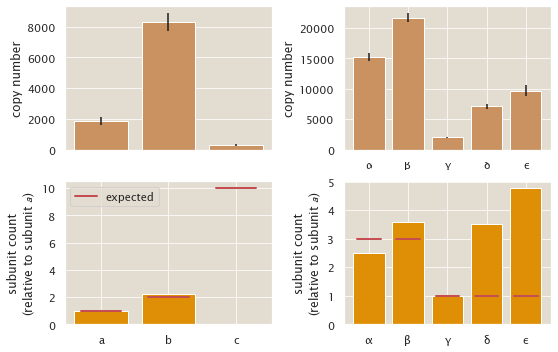

In [171]:
# set color for each dataset
pal = sns.color_palette(palette='colorblind', n_colors=8)
colorlist = pal.as_hex()

fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2,2,figsize=(8,5))

count = 0
for gene in subunit_dict.keys():
    data = combined_df_atp[combined_df_atp.Gene == gene]
    
    
    if np.any(data.Gene.unique() ==['atpB', 'atpF', 'atpE']):
        ax1.bar(count, data.copy_number.mean(),
               yerr = data.copy_number_stdev.mean(),
               color = colorlist[5])
        
        ax3.bar(count, data.copy_number.mean()/ \
                (combined_df_atp[combined_df_atp.Gene == 'atpB'].copy_number.mean()*subunit_dict[gene]),
               color = colorlist[1])
        ax3.plot([count-0.3,count+0.3], [subunit_dict[gene],subunit_dict[gene]], color='r', lw=2,
                label = 'expected')
        count += 1

for ax in [ax1,ax3]:
    ticklist = ['a', 'b', 'c']
    ax.set_xticks(np.arange(3))
    ax.set_xticklabels(ticklist)


count = 0
for gene in subunit_dict.keys():
    data = combined_df_atp[combined_df_atp.Gene == gene]
    
    
    if np.all(data.Gene.unique() !=['atpB', 'atpF', 'atpE']):
        ax2.bar(count, data.copy_number.mean(),
               yerr = data.copy_number_stdev.mean(),
               color = colorlist[5])
        
        ax4.bar(count, data.copy_number.mean()/ \
                (combined_df_atp[combined_df_atp.Gene == 'atpG'].copy_number.mean()*subunit_dict[gene]),
               color = colorlist[1])
        ax4.plot([count-0.3,count+0.3], [subunit_dict[gene],subunit_dict[gene]], color='r', lw=2)
        count += 1

ax1.set_ylabel('copy number')
ax1.set_xticks([])
ax3.set_ylabel('subunit count\n(relative to subunit $a$)')

ax2.set_ylabel('copy number')
ax2.set_xticks([])
ax4.set_ylabel('subunit count\n(relative to subunit $a$)')

for ax in [ax2,ax4]:
    ticklist =  ['α', 'β', 'γ', 'δ', 'ε']
    ax.set_xticks(np.arange(5))
    ax.set_xticklabels(ticklist)

ax3.legend()
handles, labels = ax3.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax3.legend(by_label.values(), by_label.keys())

plt.tight_layout()

## ribosome

In [173]:
genes_list = [['rpsA', 'rpsB', 'rpsC', 'rpsD', 'rpsE',
              'rpsF', 'rpsG', 'rpsH', 'rpsI', 'rpsJ', 'rpsK', 
              'rpsL', 'rpsM', 'rpsN', 'rpsO', 'rpsP', 'rpsQ', 
              'rpsR', 'rpsS', 'rpsT', 'rpsU', 'sra'],
             ['rplA', 'rplB', 'rplC', 'rplD', 'rplE', 'rplF', 'rplJ',
             'rplL', 'rplI', 'rplK', 'rplM', 'rplN', 'rplO', 'rplP', 'rplQ', 
              'rplR', 'rplS','rplT', 'rplU', 'rplV', 'rplW', 'rplX', 'rplY', 
              'rpmA', 'rpmB', 'rpmC', 'rpmD', 'rpmE', 'rpmF', 'rpmG', 'rpmH', 
              'rpmI', 'rpmJ']]

gene_list_labels=['30S ribosomal subunit',
                 '50S ribosomal subunit']

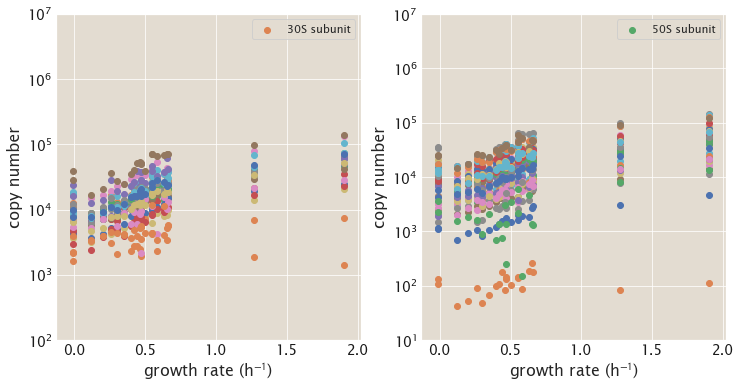

In [233]:
plot_count = len(genes_list)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))

for gene in genes_list[0]:
    data = combined_df[combined_df.Gene == gene]
    ax1.scatter(data.growth_rate, data.copy_number, label='30S subunit')
    
    ax1.set_yscale('log')
    ax1.set_ylim(100,10E6)
    
for gene in genes_list[1]:
    data = combined_df[combined_df.Gene == gene]
    ax2.scatter(data.growth_rate, data.copy_number, label='50S subunit')
    
    ax2.set_yscale('log')
    ax2.set_ylim(10,10E6)
    
for ax in [ax1,ax2]:    
    ax.set_ylabel('copy number', fontsize = 16)
    ax.set_xlabel('growth rate (h$^{-1}$)', fontsize = 16)
    ax.tick_params(axis='both', which='major', labelsize=14)

    ax.tick_params(which='major', width=1)
    ax.tick_params(which='major', length=14)
    ax.get_yaxis().set_tick_params(which='both', direction='in') 
    ax.get_xaxis().set_tick_params(which='both', direction='in') 
    ax.tick_params(axis='both', colors='white', labelcolor='k')
    
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())



Looks like there is pretty drastic variability in the measured copy number of each protein subunit. This is somewhat concerning since essentially all proteins should be present in equal molar amounts. As another check, Lets also just plot the average protein copy number for each subunit by averaging all proteins present. (Note that the only protein not in equal molar amounts is rplL, which has four monomers per 50S ; lets not worry about this for now.).

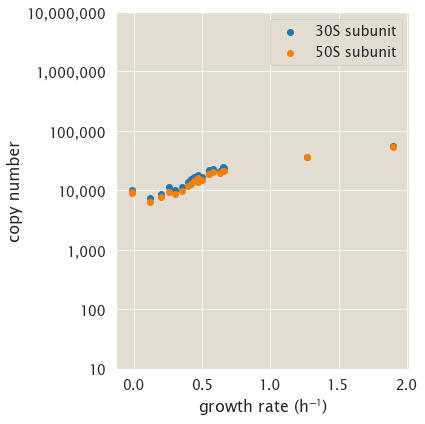

In [246]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

combined_df_30S = combined_df[combined_df.Gene.isin(genes_list[0])]
combined_df_50S = combined_df[combined_df.Gene.isin(genes_list[1])]

for cond, data in combined_df_30S.groupby('condition'):
    plt.scatter(data.growth_rate.unique(), data.copy_number.mean(), 
                label='30S subunit', color = colorlist[1])
    
for cond, data in combined_df_50S.groupby('condition'):
    plt.scatter(data.growth_rate.unique(), data.copy_number.mean(), 
                label='50S subunit', color = colorlist[7])
  
ax.set_ylabel('copy number', fontsize = 16)
ax.set_xlabel('growth rate (h$^{-1}$)', fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_yscale('log')
    
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize=14)
ax.set_ylim(10,10E6)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.tight_layout()

The average number for each subunit is pretty much spot on for 1:1, which is nice to see.

## RNA polymerase and sigma factors

RNA polymerase consists of RpoB $\beta$, RpoC $\beta$', and 2x RpoA $\alpha$. These complex with a sigma factor, which allows it to recognize a specific sequence/ DNA structure on the chomosome to begin the process of transcription. 

rpoD : sigma 70

rpoN : sigma 54

rpoH : sigma 32 (not in dataset)

rpoS : sigma 38

fliA : sigma 28

rpoE : sigma E




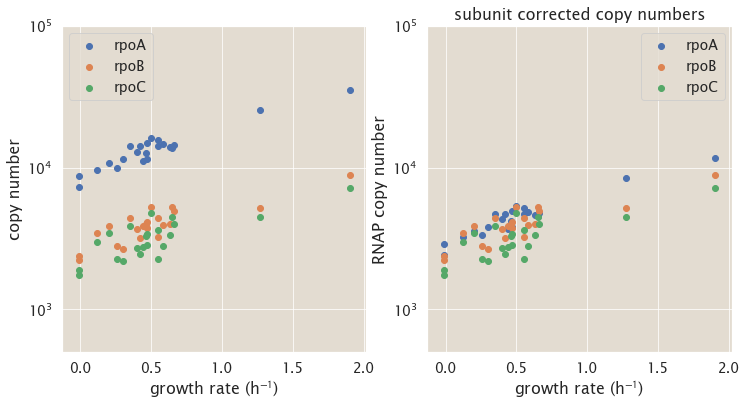

In [278]:
plot_count = len(genes_list)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))

rnap_core_dict = {'rpoA' : 3, 'rpoB' : 1, 'rpoC' : 1}

for gene in ['rpoA', 'rpoB', 'rpoC']:
    data = combined_df[combined_df.Gene == gene]
    ax1.scatter(data.growth_rate, data.copy_number, label=gene)
    ax1.set_ylabel('copy number', fontsize = 16)

    data = combined_df[combined_df.Gene == gene]
    ax2.scatter(data.growth_rate, data.copy_number/rnap_core_dict[gene], label=gene)
    ax2.set_ylabel('RNAP copy number', fontsize = 16)
    ax2.set_title('subunit corrected copy numbers', fontsize = 16)

for ax in [ax1,ax2]:
    ax.set_yscale('log')
    ax.set_ylim(500,1E5)
    
    ax.set_xlabel('growth rate (h$^{-1}$)', fontsize = 16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), fontsize=14)

Note that. in the right plot above, I've divided the number of copies of RpoA by 3 to account for there being three in each core RNA polymerase. Doesn't look too bad.

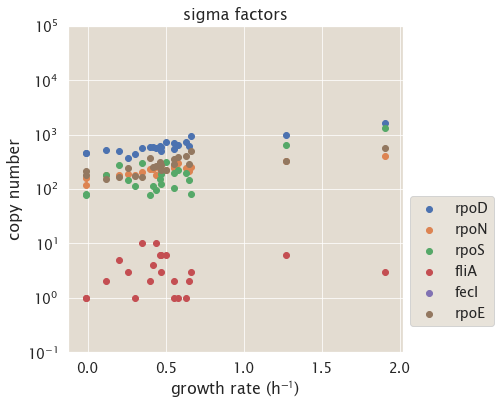

In [279]:
plot_count = len(genes_list)

fig, ax = plt.subplots(1,1, figsize=(6,6))

rnap_core_dict = {'rpoA' : 3, 'rpoB' : 1, 'rpoC' : 1}

for gene in ['rpoD', 'rpoN', 'rpoS', 'fliA', 'fecI', 'rpoE']:
    data = combined_df[combined_df.Gene == gene]
    ax.scatter(data.growth_rate, data.copy_number, label=gene)

ax.set_title('sigma factors', fontsize = 16)    
ax.set_ylabel('copy number', fontsize = 16)
ax.set_yscale('log')
ax.set_ylim(0.1,1E5)

ax.set_xlabel('growth rate (h$^{-1}$)', fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=14)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1, 0.5), fontsize=14)


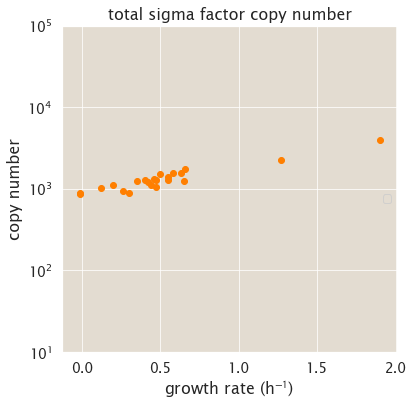

In [275]:
plot_count = len(genes_list)

fig, ax = plt.subplots(1,1, figsize=(6,6))

rnap_core_dict = {'rpoA' : 3, 'rpoB' : 1, 'rpoC' : 1}

for cond, data in combined_df[combined_df.Gene.isin(['rpoD', 'rpoN', 
                            'rpoH', 'rpoS', 'fliA', 'fecI', 'rpoE'])].groupby('condition'):
    
    ax.scatter(data.growth_rate.unique(), data.copy_number.sum(), color = colorlist[7])

    
ax.set_ylabel('copy number', fontsize = 16)
ax.set_title('total sigma factor copy number', fontsize = 16)
ax.set_yscale('log')
ax.set_ylim(10,1E5)

ax.set_xlabel('growth rate (h$^{-1}$)', fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=14)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1, 0.5))

It's interesting that the total copy number of the sigma factors is less than that of the core RNAP enzyme. 

## DNA polymerase III

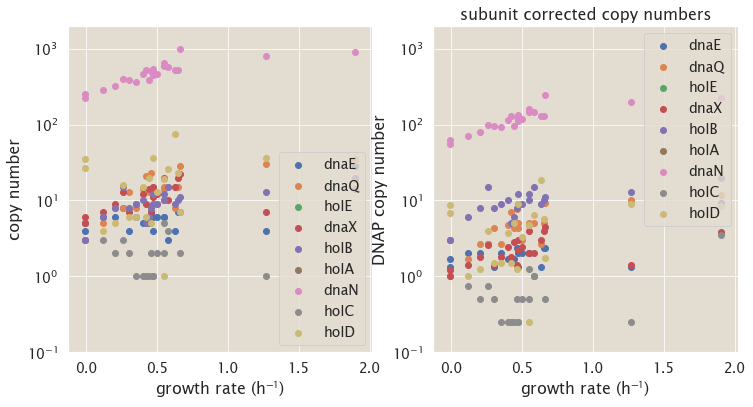

In [284]:
plot_count = len(genes_list)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))

dnap_dict = {'dnaE' : 3, 'dnaQ' : 3, 'holE' : 3, 'dnaX' : 5, 
             'holB' : 1, 'holA' : 1, 'dnaN' : 4, 'holC' : 4, 'holD' : 4}

for gene in ['dnaE', 'dnaQ', 'holE', 'dnaX', 'holB', 'holA', 'dnaN', 'holC', 'holD']:
    data = combined_df[combined_df.Gene == gene]
    ax1.scatter(data.growth_rate, data.copy_number, label=gene)
    ax1.set_ylabel('copy number', fontsize = 16)

    data = combined_df[combined_df.Gene == gene]
    ax2.scatter(data.growth_rate, data.copy_number/dnap_dict[gene], label=gene)
    ax2.set_ylabel('DNAP copy number', fontsize = 16)
    ax2.set_title('subunit corrected copy numbers', fontsize = 16)

for ax in [ax1,ax2]:
    ax.set_yscale('log')
    ax.set_ylim(0.1,2E3)
    
    ax.set_xlabel('growth rate (h$^{-1}$)', fontsize = 16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), fontsize=14)

## glucose transporters related

Expectation is that for many growth conditions that are not carbon, the copy number will not go up.

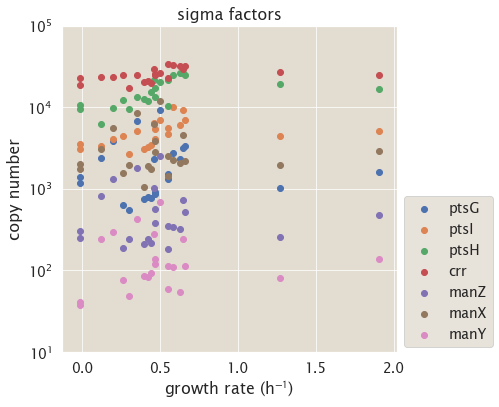

In [286]:
plot_count = len(genes_list)

fig, ax = plt.subplots(1,1, figsize=(6,6))

for gene in ['ptsG', 'ptsI', 'ptsH', 'crr', 'manZ', 'manX', 'manY']:
    data = combined_df[combined_df.Gene == gene]
    ax.scatter(data.growth_rate, data.copy_number, label=gene)

ax.set_title('sigma factors', fontsize = 16)    
ax.set_ylabel('copy number', fontsize = 16)
ax.set_yscale('log')
ax.set_ylim(10,1E5)

ax.set_xlabel('growth rate (h$^{-1}$)', fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=14)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1, 0.5), fontsize=14)

There does seem to be some spread in the values for similar growth rates. For example macY and manZ. Lets look at these further.

In [311]:
#growth conditions with glucose
cond_glu = ['Glucose', 'Osmotic-stress glucose','pH6 glucose', '42°C glucose', 
 'stationary_1day', 'stationary_3day', 'Chemostat µ=0.5',
       'Chemostat µ=0.35', 'Chemostat µ=0.20', 'Chemostat µ=0.12']

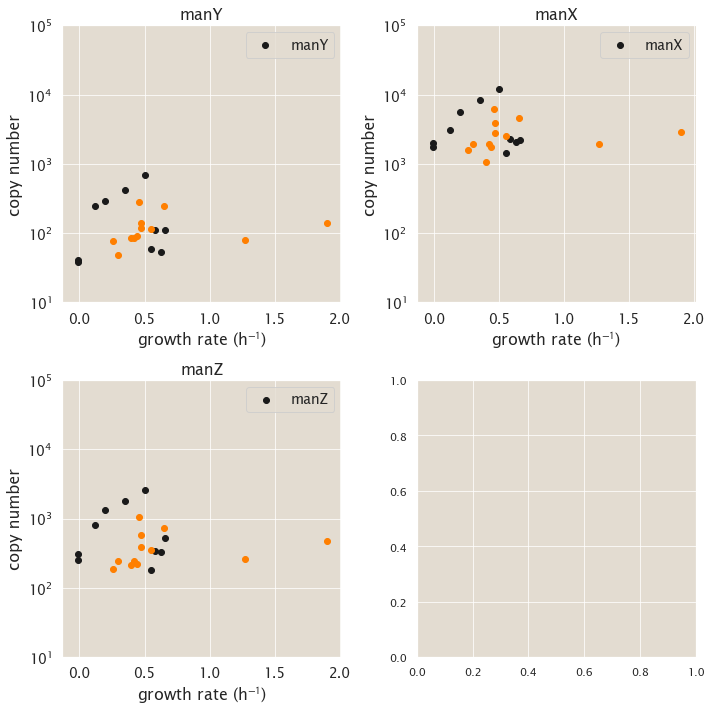

In [310]:
plot_count = len(genes_list)

fig, ([ax1, ax2],[ax3, ax4]) = plt.subplots(2,2, figsize=(10,10))


for cond, data in combined_df[combined_df.Gene == 'manY'].groupby('condition'):
    if cond in cond_glu:
        c = 'k'
    else: c = colorlist[7]
    ax1.scatter(data.growth_rate, data.copy_number, label='manY', color = c)
    ax1.set_title('manY', fontsize = 16)  
    
for cond, data in combined_df[combined_df.Gene == 'manX'].groupby('condition'):
    if cond in cond_glu:
        c = 'k'
    else: c = colorlist[7]
    ax2.scatter(data.growth_rate, data.copy_number, label='manX', color = c)
    ax2.set_title('manX', fontsize = 16)

for cond, data in combined_df[combined_df.Gene == 'manZ'].groupby('condition'):
    if cond in cond_glu:
        c = 'k'
    else: c = colorlist[7]
    ax3.scatter(data.growth_rate, data.copy_number, label='manZ', color = c)
    ax3.set_title('manZ', fontsize = 16)

for ax in [ax1,ax2,ax3]:
    ax.set_ylabel('copy number', fontsize = 16)
    ax.set_yscale('log')
    ax.set_ylim(10,1E5)

    ax.set_xlabel('growth rate (h$^{-1}$)', fontsize = 16)
    ax.tick_params(axis='both', which='major', labelsize=14)

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), fontsize=14)
    
plt.tight_layout()

Interesting. It's actually the chemostat conditions that correspond to the four outliers that show higher copy number. 

## fatty acid syntases

Ecocyc: There are three β-ketoacyl-ACP synthases (KAS) in E. coli: KASI, KASII and KASIII, encoded by fabB, fabF and fabH, respectively. All three are genetically and biochemically distinct. Each of the three enzymes is capable of initiating fatty acid biosynthesis.

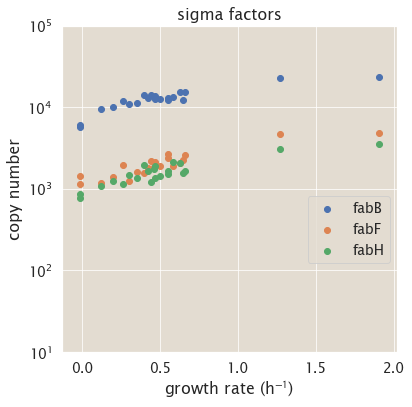

In [287]:
plot_count = len(genes_list)

fig, ax = plt.subplots(1,1, figsize=(6,6))

for gene in ['fabB', 'fabF', 'fabH']:
    data = combined_df[combined_df.Gene == gene]
    ax.scatter(data.growth_rate, data.copy_number, label=gene)

ax.set_title('sigma factors', fontsize = 16)    
ax.set_ylabel('copy number', fontsize = 16)
ax.set_yscale('log')
ax.set_ylim(10,1E5)

ax.set_xlabel('growth rate (h$^{-1}$)', fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=14)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1, 0.5), fontsize=14)